In [72]:
import torch,torchvision
from torchvision.datasets.utils import download_url
from torchvision import transforms,models
from torchvision.utils import make_grid
import os
import tarfile
import tqdm
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchsummary import summary
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau,ExponentialLR
import json

### Setup and Configurations, Loading Data

In [2]:
dataset_url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
os.makedirs('/dataset/',exist_ok=True)
download_url(dataset_url,'dataset')

Using downloaded and verified file: dataset\cifar-10-python.tar.gz


In [3]:
with tarfile.open("dataset/"+dataset_url.split('/')[-1],'r:gz') as f:
    f.extractall(path='dataset',filter=None)

C:\Users\dhash\AppData\Local\Temp\ipykernel_18516\4291131392.py:2: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  f.extractall(path='dataset',filter=None)


In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [5]:
train=torchvision.datasets.CIFAR10(root='dataset',transform=transforms.ToTensor(),train=True)
test=torchvision.datasets.CIFAR10(root='dataset',transform=transforms.ToTensor(),train=False)
print(train,test,sep='\n')

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: dataset
    Split: Test
    StandardTransform
Transform: ToTensor()


### EDA

train features shape:  (50000, 32, 32, 3)
train classes shape:  50000
test features shape:  (10000, 32, 32, 3)
test classes shape:  10000


C:\Users\dhash\AppData\Local\Temp\ipykernel_18516\2513241928.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


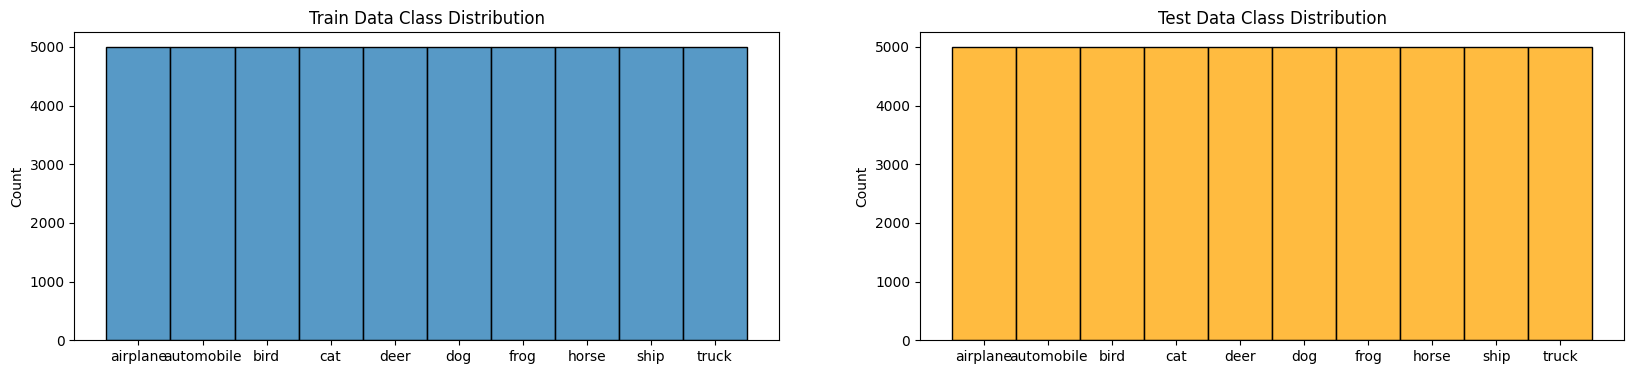

In [6]:
## EDA on the data

print('train features shape: ',train.data.shape)
print('train classes shape: ',len(train.targets))
print('test features shape: ',test.data.shape)
print('test classes shape: ',len(test.targets))

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(20,4))
ax[0]=sns.histplot((train.targets),discrete=True,legend=True,ax=ax[0])
ax[0].set_xticks(range(10))
ax[0].set_xticklabels(train.classes)
ax[0].set_title('Train Data Class Distribution')

ax[1]=sns.histplot((train.targets),discrete=True,legend=True,ax=ax[1],color='orange')
ax[1].set_xticks(range(10))
ax[1].set_xticklabels(train.classes)
ax[1].set_title('Test Data Class Distribution')

fig.show()

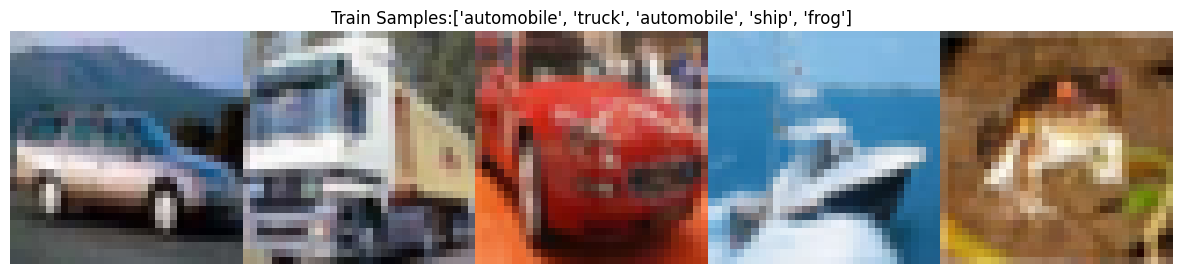

In [7]:
samples=np.random.randint(0,len(train.class_to_idx),(5))
fig,ax=plt.subplots(figsize=(15,10))
ax.imshow(make_grid(torch.from_numpy(train.data[samples]),nrow=1,padding=0))
plt.axis('off')
plt.title(f'Train Samples:{[train.classes[train.targets[i]] for i in samples]}')
plt.show()

### Splitting and Transformations

In [8]:
## try this later from pytorch https://pytorch.org/hub/pytorch_vision_resnet/
## reference this https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.49139968, 0.48215827 ,0.44653124),std=(0.24703233,0.24348505,0.26158768))
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827 ,0.44653124),(0.24703233,0.24348505,0.26158768))
])
train=torchvision.datasets.CIFAR10(root='dataset',transform=train_transform,train=True)
test=torchvision.datasets.CIFAR10(root='dataset',transform=test_transform,train=False)

In [9]:
batch_size=64
torch.random.seed()
train,valid=random_split(train,[len(train.targets)-len(test.targets),len(test.targets)])
train_dataloader=DataLoader(train,batch_size,num_workers=4,pin_memory=True,shuffle=True)
valid_dataloader=DataLoader(valid,batch_size,num_workers=4,pin_memory=True)
test_datalaoder=DataLoader(test,batch_size,num_workers=4,pin_memory=True)

In [10]:
print('Train Data Length:',len(train_dataloader.dataset.indices))
print('Valid Data Length:',len(valid_dataloader.dataset.indices))
print('Test Dataset Length:',len(test_datalaoder.dataset.targets))

Train Data Length: 40000
Valid Data Length: 10000
Test Dataset Length: 10000


### Experimentaion

In [11]:
def train_model(model,train_dataloader,loss_fn,optimizer,train_loss,train_accuracy):
    
    model.train()
    total_loss=0
    accuracy=0
    
    for batch,(data,target) in enumerate(train_dataloader):
        data=data.to('cuda',non_blocking=True)
        target=target.to('cuda',non_blocking=True)
        optimizer.zero_grad()
       
        predictions=model(data)
        #loss=nn.CrossEntropyLoss(predictions,target)
        loss=loss_fn(predictions,target)
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        #print('loss:',loss.item())      
        #pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch} Accuracy={100*correct/processed:0.2f}')
        accuracy+=(predictions.argmax(dim=1)==target).sum()
    
    train_loss.append(total_loss/len(train_dataloader.dataset.indices))
    train_accuracy.append(accuracy/len(train_dataloader.dataset.indices))
    
def validate_model(model,valid_dataloader,loss_fn,val_loss,val_accuracy):
    model.eval()
    total_loss=0
    accuracy=0
    with torch.no_grad():
        for batch,(data,target) in enumerate(valid_dataloader):
            data=data.to('cuda',non_blocking=True)
            target=target.to('cuda',non_blocking=True)

            predictions=model(data)
            loss=loss_fn(predictions,target)
            total_loss+=loss.item()

            accuracy+=(predictions.argmax(dim=1)==target).sum()
    val_loss.append(total_loss/len(valid_dataloader.dataset.indices))
    val_accuracy.append(accuracy/len(valid_dataloader.dataset.indices))
    
        

In [12]:
def fit(model,loss,optim,epcohs=50,scheduler=None,plot=False):
    train_accuracy=[]
    train_loss=[]
    val_accuracy=[]
    val_loss=[]
    
    for i in range(epcohs):
        train_model(model,train_dataloader,loss,optim,train_loss,train_accuracy)
        validate_model(model,valid_dataloader,loss,val_loss,val_accuracy)
        if(scheduler is not None):
            scheduler.step(val_loss[-1])
            print(f'epoch {i+1}, lr {scheduler.get_last_lr()} -- train loss: {train_loss[-1]}, train accuracy: {train_accuracy[-1]*100},  val loss: {val_loss[-1]} , val accuracy: {val_accuracy[-1]*100}')
            continue
        
        print(f'epoch {i+1}, lr {optim.param_groups[0]['lr']} -- train loss: {train_loss[-1]}, train accuracy: {train_accuracy[-1]*100},  val loss: {val_loss[-1]} , val accuracy: {val_accuracy[-1]*100}')
    
    if(plot):
        plt.figure(figsize=(15,8))
        plt.plot(range(1,epcohs+1),train_loss,label='training loss')
        plt.plot(range(1,epcohs+1),val_loss,label='validation loss')
        plt.show()
    return train_loss,train_accuracy,val_loss,val_accuracy

#### Resnet

In [13]:
resnet=models.resnet18(weights=None)
resnet.fc=nn.Linear(resnet.fc.in_features,10)
summary(resnet.to('cuda',non_blocking=True),input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

epoch 1, lr [0.001] -- train loss: 0.03233795637190342, train accuracy: 24.76249885559082,  val loss: 0.02985117726325989 , val accuracy: 31.14999771118164
epoch 2, lr [0.001] -- train loss: 0.028677245712280273, train accuracy: 32.685001373291016,  val loss: 0.027807394993305205 , val accuracy: 34.46999740600586
epoch 3, lr [0.001] -- train loss: 0.02708330157995224, train accuracy: 36.34499740600586,  val loss: 0.026549732267856598 , val accuracy: 37.459999084472656
epoch 4, lr [0.001] -- train loss: 0.025965522706508638, train accuracy: 39.17749786376953,  val loss: 0.025492626321315767 , val accuracy: 40.29999923706055
epoch 5, lr [0.001] -- train loss: 0.025084609958529472, train accuracy: 41.26749801635742,  val loss: 0.024740255057811737 , val accuracy: 41.48999786376953
epoch 6, lr [0.001] -- train loss: 0.024241167470812796, train accuracy: 43.442501068115234,  val loss: 0.023864109659194947 , val accuracy: 44.599998474121094
epoch 7, lr [0.001] -- train loss: 0.02350548108220

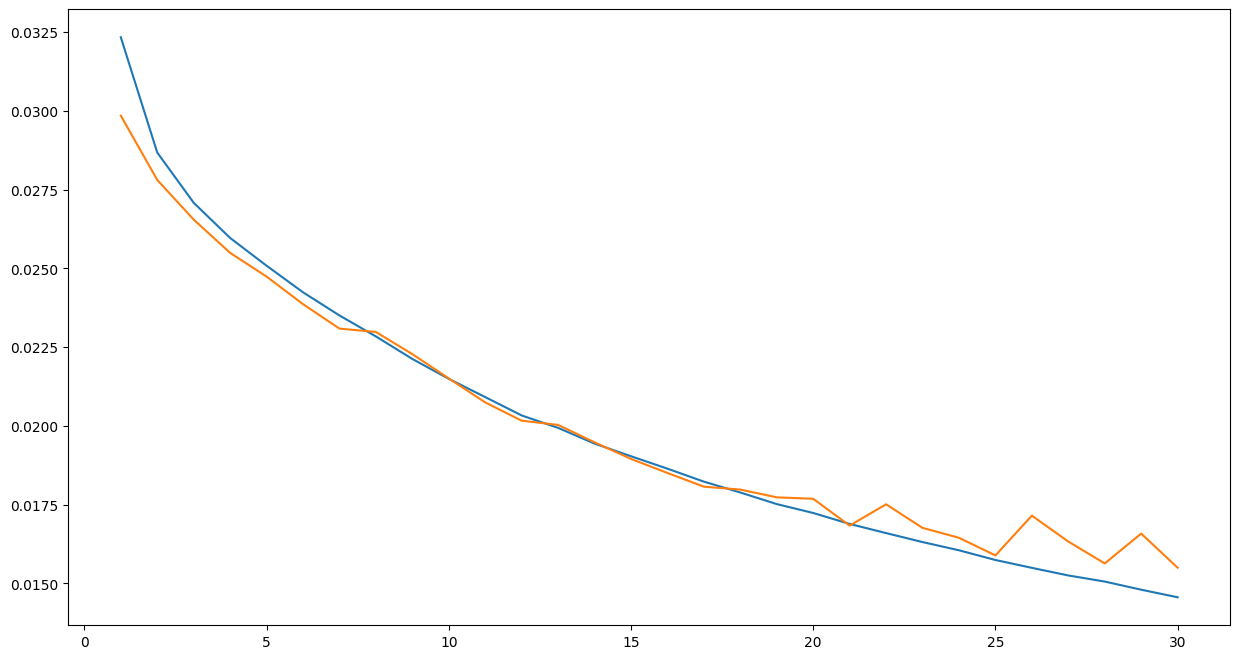

In [23]:
##resnet18
## test for sgd with lr =0.001
model=models.resnet18(weights=None)
model.fc=nn.Linear(model.fc.in_features,10)
model.to('cuda')

loss=nn.CrossEntropyLoss()

lr=0.001
momentum=0
weight_decay=1e-6
optim=torch.optim.SGD(model.parameters(),lr,momentum,weight_decay)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,30,scheduler=scheduler,plot=True)

torch.save(model,'resnet18_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('resnet18_'+str(lr)+'_'+str(momentum)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

epoch 1, lr [0.0001] -- train loss: 0.03284955426752567, train accuracy: 24.047500610351562,  val loss: 0.030486460959911345 , val accuracy: 29.35999870300293
epoch 2, lr [0.0001] -- train loss: 0.02898054329752922, train accuracy: 32.06999969482422,  val loss: 0.027852360033988954 , val accuracy: 35.310001373291016
epoch 3, lr [0.0001] -- train loss: 0.027061394029855728, train accuracy: 36.57499694824219,  val loss: 0.026331598019599913 , val accuracy: 38.7400016784668
epoch 4, lr [0.0001] -- train loss: 0.025795930564403532, train accuracy: 39.682498931884766,  val loss: 0.0253311882853508 , val accuracy: 40.81999969482422
epoch 5, lr [0.0001] -- train loss: 0.024743041488528253, train accuracy: 42.40250015258789,  val loss: 0.024273949933052062 , val accuracy: 43.5099983215332
epoch 6, lr [0.0001] -- train loss: 0.023948163345456124, train accuracy: 44.25749969482422,  val loss: 0.024088728404045107 , val accuracy: 44.380001068115234
epoch 7, lr [0.0001] -- train loss: 0.0232375631

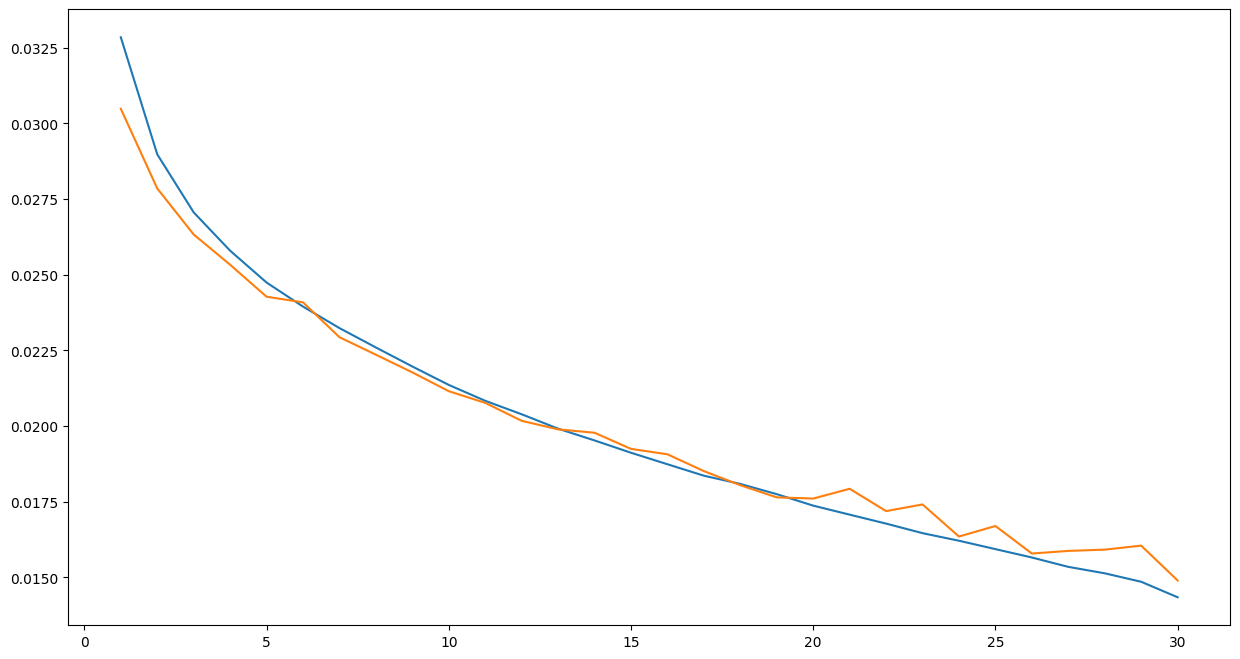

In [27]:
##resnet18
## test for sgd with lr =0.0001 and momentum=0.9
model=models.resnet18(weights=None)
model.fc=nn.Linear(model.fc.in_features,10)
model.to('cuda')

loss=nn.CrossEntropyLoss()

lr=0.0001
momentum=0.9
weight_decay=1e-6
optim=torch.optim.SGD(model.parameters(),lr,momentum=momentum,weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,30,scheduler=scheduler,plot=True)

torch.save(model,'resnet18_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('resnet18_'+str(lr)+'_'+str(momentum)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

epoch 1, lr [1e-06] -- train loss: 0.03391568596959114, train accuracy: 19.6924991607666,  val loss: 0.03174534869194031 , val accuracy: 26.749998092651367
epoch 2, lr [1e-06] -- train loss: 0.030332877019047737, train accuracy: 30.17999839782715,  val loss: 0.029257641792297364 , val accuracy: 33.66999816894531
epoch 3, lr [1e-06] -- train loss: 0.02836066217124462, train accuracy: 34.992496490478516,  val loss: 0.02757352645397186 , val accuracy: 37.709999084472656
epoch 4, lr [1e-06] -- train loss: 0.02694223023056984, train accuracy: 38.38749694824219,  val loss: 0.026282212686538697 , val accuracy: 40.529998779296875
epoch 5, lr [1e-06] -- train loss: 0.02580500621199608, train accuracy: 41.04999923706055,  val loss: 0.025193379485607147 , val accuracy: 42.63999938964844
epoch 6, lr [1e-06] -- train loss: 0.0248281218200922, train accuracy: 43.11499786376953,  val loss: 0.024231834053993224 , val accuracy: 44.47999954223633
epoch 7, lr [1e-06] -- train loss: 0.023938136231899262, 

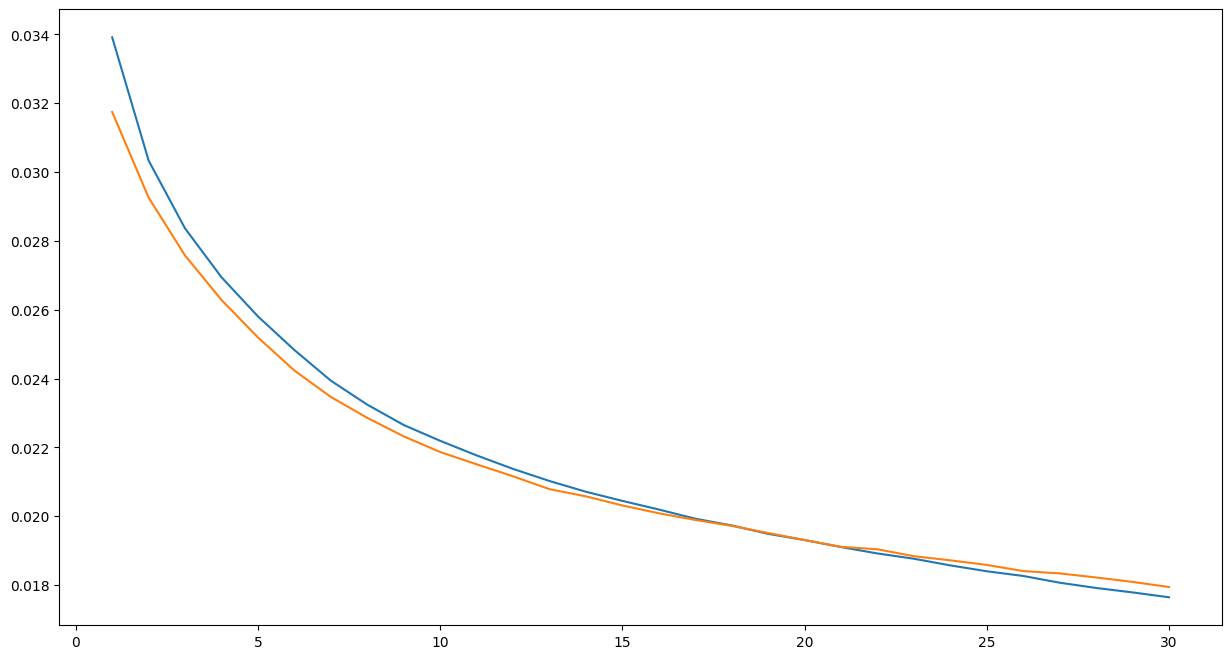

In [34]:
##resnet18
## test for adam with lr =0.001
model=models.resnet18(weights=None)
model.fc=nn.Linear(model.fc.in_features,10)
model.to('cuda')

loss=nn.CrossEntropyLoss()

lr=0.000001
momentum=0
weight_decay=1e-6
optim=torch.optim.Adam(model.parameters(),lr,weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.01, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,30,scheduler=scheduler,plot=True)

torch.save(model,'resnet18_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('resnet18_'+str(lr)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

#### Mobilenet

In [49]:
model=models.MobileNetV2(width_mult=0.5,num_classes=10)
summary(model.to('cuda',non_blocking=True),input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
             ReLU6-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 16, 112, 112]             144
       BatchNorm2d-5         [-1, 16, 112, 112]              32
             ReLU6-6         [-1, 16, 112, 112]               0
            Conv2d-7          [-1, 8, 112, 112]             128
       BatchNorm2d-8          [-1, 8, 112, 112]              16
  InvertedResidual-9          [-1, 8, 112, 112]               0
           Conv2d-10         [-1, 48, 112, 112]             384
      BatchNorm2d-11         [-1, 48, 112, 112]              96
            ReLU6-12         [-1, 48, 112, 112]               0
           Conv2d-13           [-1, 48, 56, 56]             432
      BatchNorm2d-14           [-1, 48,

epoch 1, lr [0.001] -- train loss: 0.03560363217592239, train accuracy: 13.55250072479248,  val loss: 0.035168941354751584 , val accuracy: 17.18000030517578
epoch 2, lr [0.001] -- train loss: 0.03421180731654167, train accuracy: 18.36749839782715,  val loss: 0.03326961326599121 , val accuracy: 21.28999900817871
epoch 3, lr [0.001] -- train loss: 0.03169902009665966, train accuracy: 23.822500228881836,  val loss: 0.03018963656425476 , val accuracy: 28.139999389648438
epoch 4, lr [0.001] -- train loss: 0.02915873923897743, train accuracy: 28.237497329711914,  val loss: 0.02823902871608734 , val accuracy: 30.849998474121094
epoch 5, lr [0.001] -- train loss: 0.02795109939277172, train accuracy: 30.32499885559082,  val loss: 0.027480321168899535 , val accuracy: 31.93000030517578
epoch 6, lr [0.001] -- train loss: 0.027274842676520347, train accuracy: 32.040000915527344,  val loss: 0.026954891836643218 , val accuracy: 33.349998474121094
epoch 7, lr [0.001] -- train loss: 0.02679168206155300

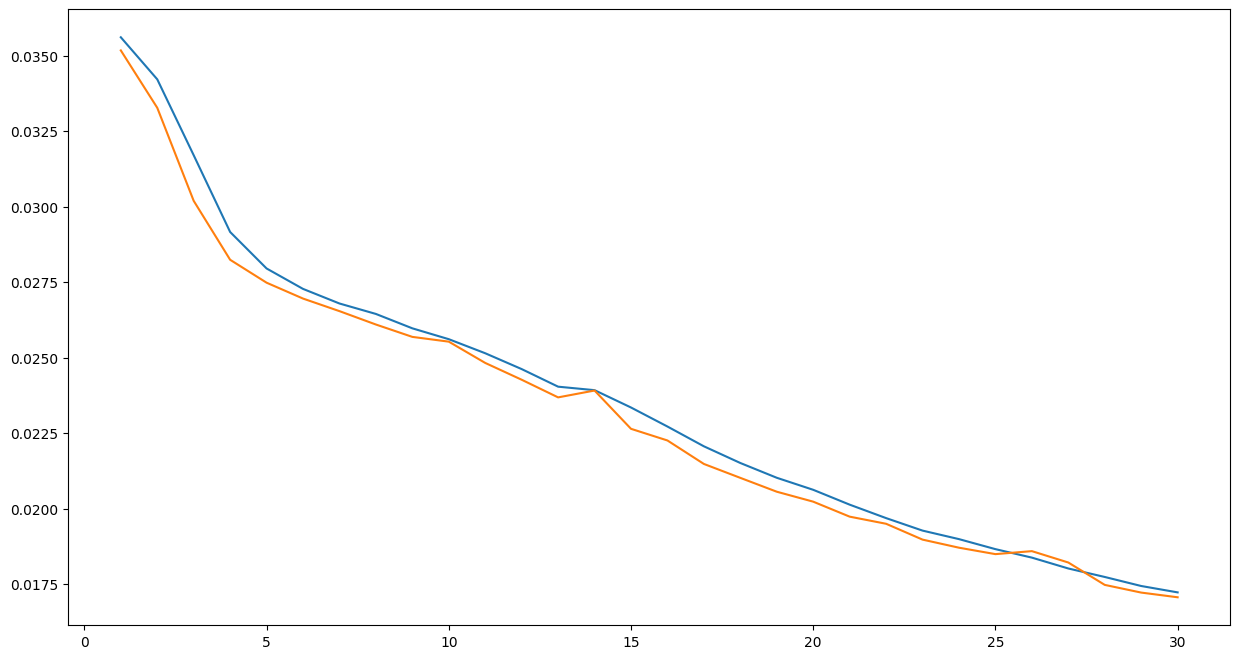

In [61]:
##mobilnetv2
## test for adam, lr=0.00001
model=models.MobileNetV2(num_classes=10,width_mult=0.5)
model.to('cuda')

loss=nn.CrossEntropyLoss()

lr=0.001
momentum=0
weight_decay=1e-6
optim=torch.optim.SGD(model.parameters(),lr,weight_decay=weight_decay,momentum=momentum)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.01, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,30,scheduler=scheduler,plot=True)

torch.save(model,'mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

epoch 1, lr [0.0001] -- train loss: 0.03550497179627418, train accuracy: 13.769999504089355,  val loss: 0.03507187933921814 , val accuracy: 17.829999923706055
epoch 2, lr [0.0001] -- train loss: 0.03361710083782673, train accuracy: 19.545000076293945,  val loss: 0.032039419960975646 , val accuracy: 24.759998321533203
epoch 3, lr [0.0001] -- train loss: 0.03034027034342289, train accuracy: 26.00749969482422,  val loss: 0.029155767798423767 , val accuracy: 29.079999923706055
epoch 4, lr [0.0001] -- train loss: 0.028457714277505874, train accuracy: 29.284997940063477,  val loss: 0.027875498044490816 , val accuracy: 31.849998474121094
epoch 5, lr [0.0001] -- train loss: 0.027642500591278076, train accuracy: 31.36749839782715,  val loss: 0.02737174574136734 , val accuracy: 32.119998931884766
epoch 6, lr [0.0001] -- train loss: 0.027225201418995856, train accuracy: 32.54999923706055,  val loss: 0.02676435468196869 , val accuracy: 34.709999084472656
epoch 7, lr [0.0001] -- train loss: 0.02663

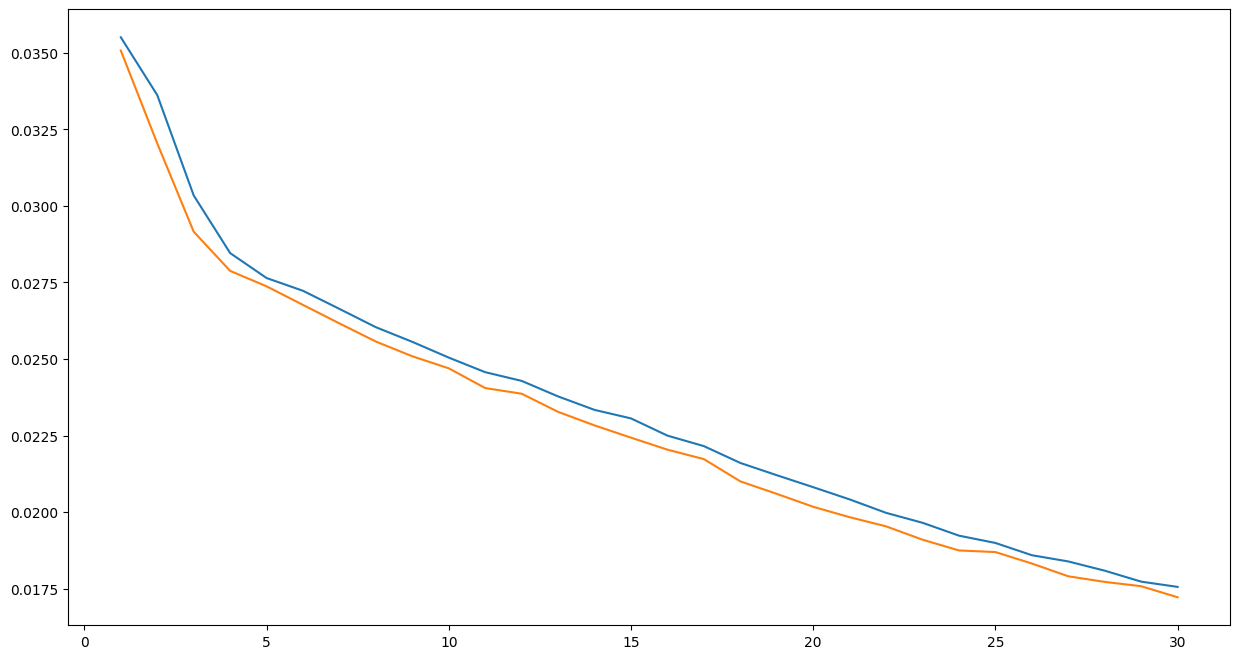

In [71]:
##mobilnetv2
## test for adam, lr=0.00001
model=models.MobileNetV2(num_classes=10,width_mult=0.5)
model.to('cuda')

loss=nn.CrossEntropyLoss()

lr=0.0001
momentum=0.9
weight_decay=1e-6
optim=torch.optim.SGD(model.parameters(),lr,weight_decay=weight_decay,momentum=momentum)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.01, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,30,scheduler=scheduler,plot=True)

torch.save(model,'mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

epoch 1, lr [1e-05] -- train loss: 0.03504597390294075, train accuracy: 15.875,  val loss: 0.03397502257823944 , val accuracy: 20.969999313354492
epoch 2, lr [1e-05] -- train loss: 0.03155177405774593, train accuracy: 24.54749870300293,  val loss: 0.029930035471916198 , val accuracy: 28.25
epoch 3, lr [1e-05] -- train loss: 0.02929257712364197, train accuracy: 28.51249885559082,  val loss: 0.028616800916194916 , val accuracy: 31.25
epoch 4, lr [1e-05] -- train loss: 0.02832260241806507, train accuracy: 31.479999542236328,  val loss: 0.02798944699764252 , val accuracy: 32.849998474121094
epoch 5, lr [1e-05] -- train loss: 0.027630258029699324, train accuracy: 33.64250183105469,  val loss: 0.027267016160488128 , val accuracy: 35.09000015258789
epoch 6, lr [1e-05] -- train loss: 0.027118722298741342, train accuracy: 35.17749786376953,  val loss: 0.026847294676303864 , val accuracy: 36.0099983215332
epoch 7, lr [1e-05] -- train loss: 0.026626092916727066, train accuracy: 36.61499786376953,

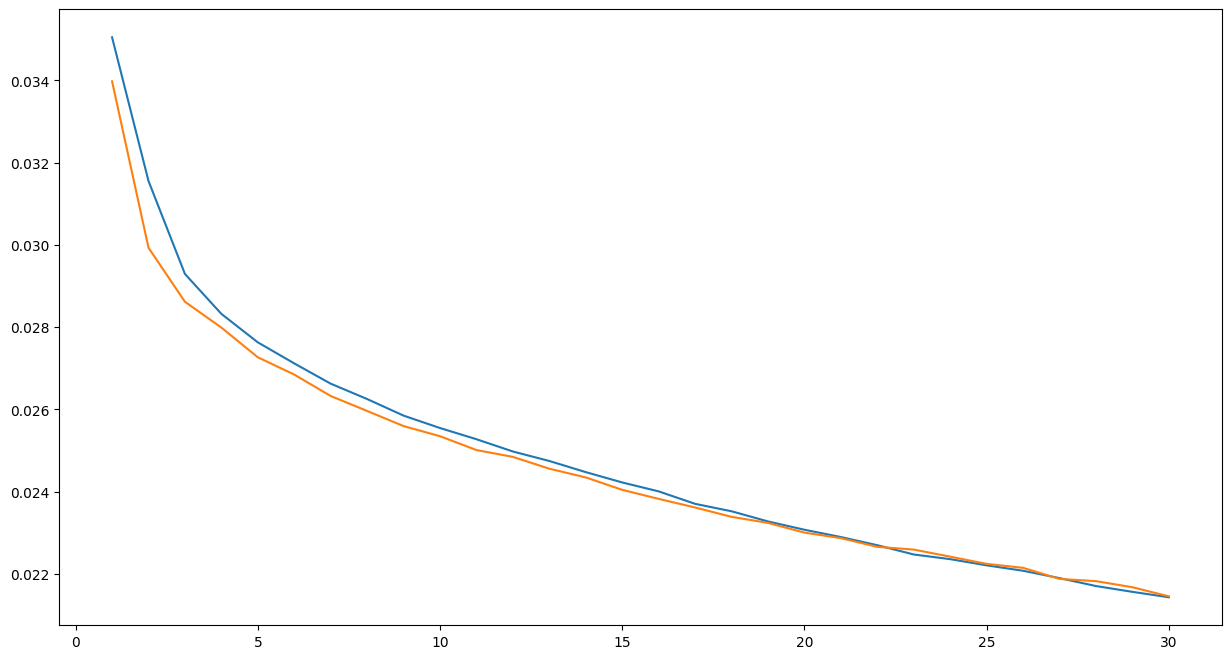

In [59]:
##mobilnetv2
## test for adam, lr=0.00001
model=models.MobileNetV2(num_classes=10,width_mult=0.5)
model.to('cuda')

loss=nn.CrossEntropyLoss()

lr=0.00001
momentum=0
weight_decay=1e-6
optim=torch.optim.Adam(model.parameters(),lr,weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.01, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,30,scheduler=scheduler,plot=True)

torch.save(model,'mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

#### Shufflenet

In [62]:
model=models.shufflenet_v2_x0_5(weights=None)
model.fc=nn.Linear(model.fc.in_features,10)
summary(model.to('cuda',non_blocking=True),input_size=(3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
         MaxPool2d-4           [-1, 24, 56, 56]               0
            Conv2d-5           [-1, 24, 28, 28]             216
       BatchNorm2d-6           [-1, 24, 28, 28]              48
            Conv2d-7           [-1, 24, 28, 28]             576
       BatchNorm2d-8           [-1, 24, 28, 28]              48
              ReLU-9           [-1, 24, 28, 28]               0
           Conv2d-10           [-1, 24, 56, 56]             576
      BatchNorm2d-11           [-1, 24, 56, 56]              48
             ReLU-12           [-1, 24, 56, 56]               0
           Conv2d-13           [-1, 24, 28, 28]             216
      BatchNorm2d-14           [-1, 24,

epoch 1, lr [0.01] -- train loss: 0.03298599423766136, train accuracy: 20.34000015258789,  val loss: 0.02934592560529709 , val accuracy: 26.469999313354492
epoch 2, lr [0.01] -- train loss: 0.027751051688194275, train accuracy: 31.0674991607666,  val loss: 0.027156024110317232 , val accuracy: 32.189998626708984
epoch 3, lr [0.01] -- train loss: 0.026033408042788506, train accuracy: 36.189998626708984,  val loss: 0.025216277801990507 , val accuracy: 39.02000045776367
epoch 4, lr [0.01] -- train loss: 0.024637900814414023, train accuracy: 40.80999755859375,  val loss: 0.023679812681674958 , val accuracy: 43.86000061035156
epoch 5, lr [0.01] -- train loss: 0.023376258027553557, train accuracy: 44.40999984741211,  val loss: 0.02261026839017868 , val accuracy: 46.429996490478516
epoch 6, lr [0.01] -- train loss: 0.02219718361198902, train accuracy: 47.55999755859375,  val loss: 0.02174515187740326 , val accuracy: 49.089996337890625
epoch 7, lr [0.01] -- train loss: 0.0212593404263258, train

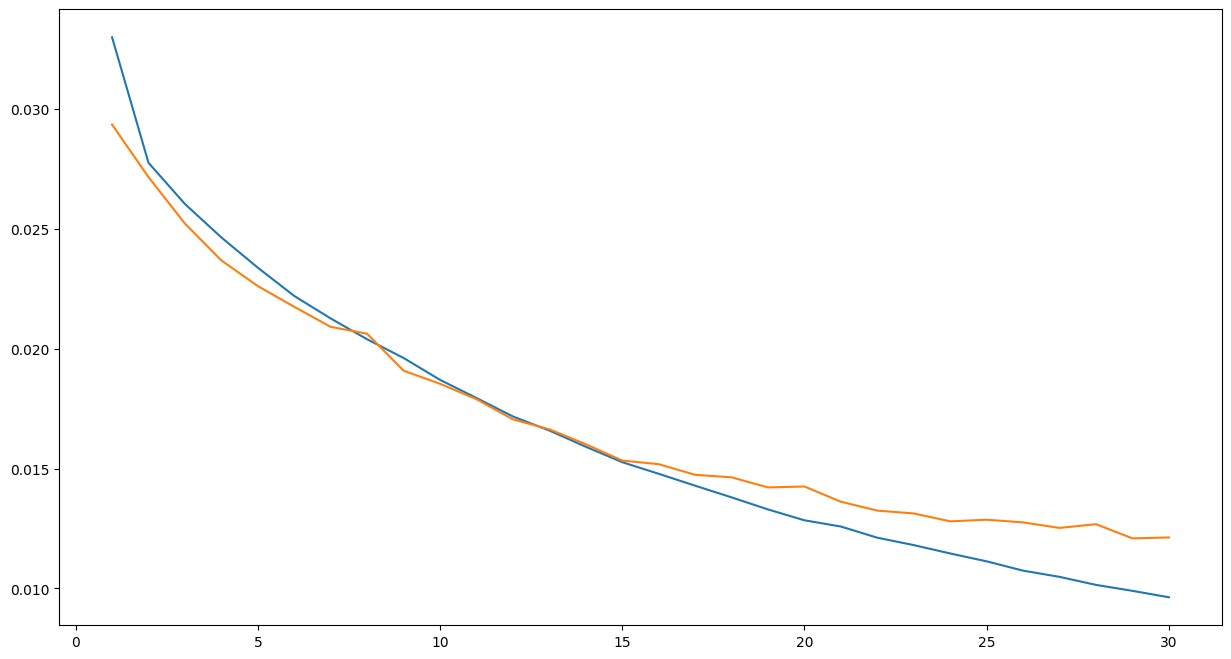

In [67]:
##shufflenet
## test for sgd,lr=0.001,momentum
model=models.shufflenet_v2_x0_5(weights=None)
model.fc=nn.Linear(model.fc.in_features,10)
model.to('cuda')


loss=nn.CrossEntropyLoss()

lr=0.01
momentum=0
weight_decay=1e-6
optim=torch.optim.SGD(model.parameters(),lr,weight_decay=weight_decay,momentum=momentum)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.01, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,30,scheduler=scheduler,plot=True)

torch.save(model,'mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

epoch 1, lr [0.001] -- train loss: 0.034751072627305986, train accuracy: 16.092500686645508,  val loss: 0.03359392409324646 , val accuracy: 18.35999870300293
epoch 2, lr [0.001] -- train loss: 0.032299300864338874, train accuracy: 19.477500915527344,  val loss: 0.03141501747369766 , val accuracy: 20.940000534057617
epoch 3, lr [0.001] -- train loss: 0.030967883613705637, train accuracy: 21.822498321533203,  val loss: 0.030730791568756105 , val accuracy: 22.479999542236328
epoch 4, lr [0.001] -- train loss: 0.0302001363247633, train accuracy: 24.579998016357422,  val loss: 0.029880401039123535 , val accuracy: 26.909997940063477
epoch 5, lr [0.001] -- train loss: 0.029348570734262468, train accuracy: 28.472497940063477,  val loss: 0.029059738039970397 , val accuracy: 30.21000099182129
epoch 6, lr [0.001] -- train loss: 0.028427228194475174, train accuracy: 30.63249969482422,  val loss: 0.02806427298784256 , val accuracy: 31.65999984741211
epoch 7, lr [0.001] -- train loss: 0.027699305391

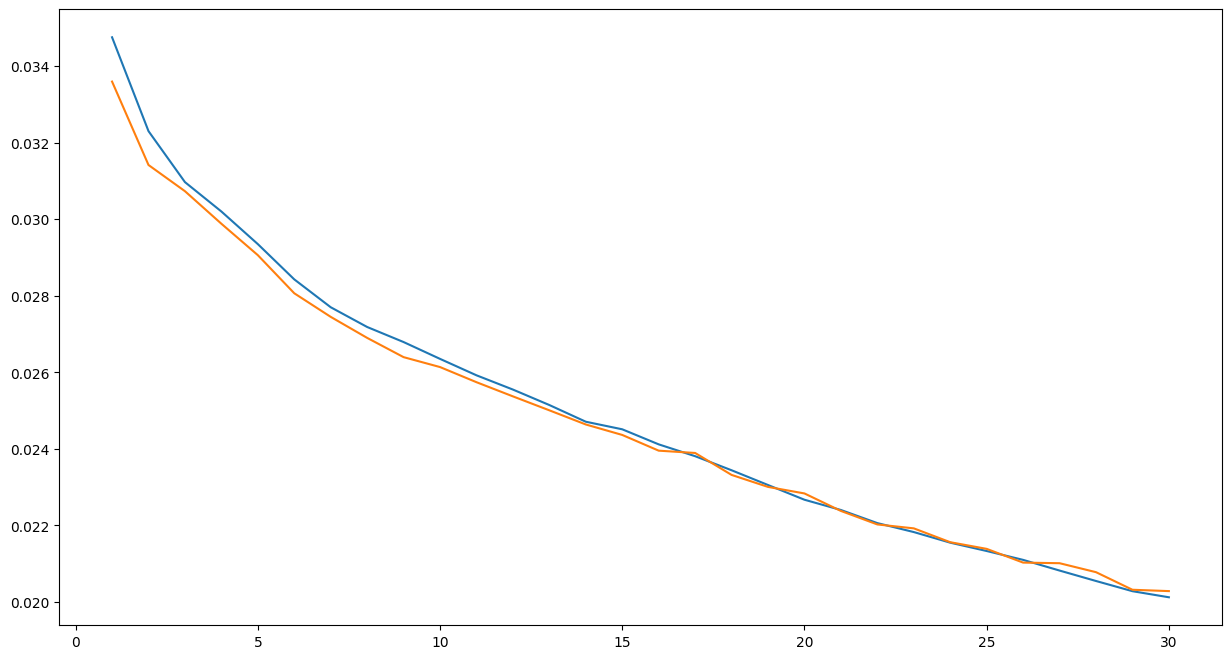

In [69]:
##shufflenet
## test for sgd,adam, lr=0.0001,momentum
model=models.shufflenet_v2_x0_5(weights=None)
model.fc=nn.Linear(model.fc.in_features,10)
model.to('cuda')


loss=nn.CrossEntropyLoss()

lr=0.001
momentum=0.5
weight_decay=1e-6
optim=torch.optim.SGD(model.parameters(),lr,weight_decay=weight_decay,momentum=momentum)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.01, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,30,scheduler=scheduler,plot=True)

torch.save(model,'mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

epoch 1, lr [0.0001] -- train loss: 0.03111279295682907, train accuracy: 25.029998779296875,  val loss: 0.027832370007038115 , val accuracy: 33.96999740600586
epoch 2, lr [0.0001] -- train loss: 0.026404573753476143, train accuracy: 36.644996643066406,  val loss: 0.025450322914123535 , val accuracy: 39.06999969482422
epoch 3, lr [0.0001] -- train loss: 0.02469458762705326, train accuracy: 41.404998779296875,  val loss: 0.024126114153862 , val accuracy: 42.849998474121094
epoch 4, lr [0.0001] -- train loss: 0.023571394926309587, train accuracy: 44.492496490478516,  val loss: 0.023152299523353577 , val accuracy: 45.839996337890625
epoch 5, lr [0.0001] -- train loss: 0.022609714704751968, train accuracy: 46.912498474121094,  val loss: 0.022368872773647307 , val accuracy: 47.88999938964844
epoch 6, lr [0.0001] -- train loss: 0.021895336186885835, train accuracy: 48.35499954223633,  val loss: 0.02178411921262741 , val accuracy: 48.959999084472656
epoch 7, lr [0.0001] -- train loss: 0.021228

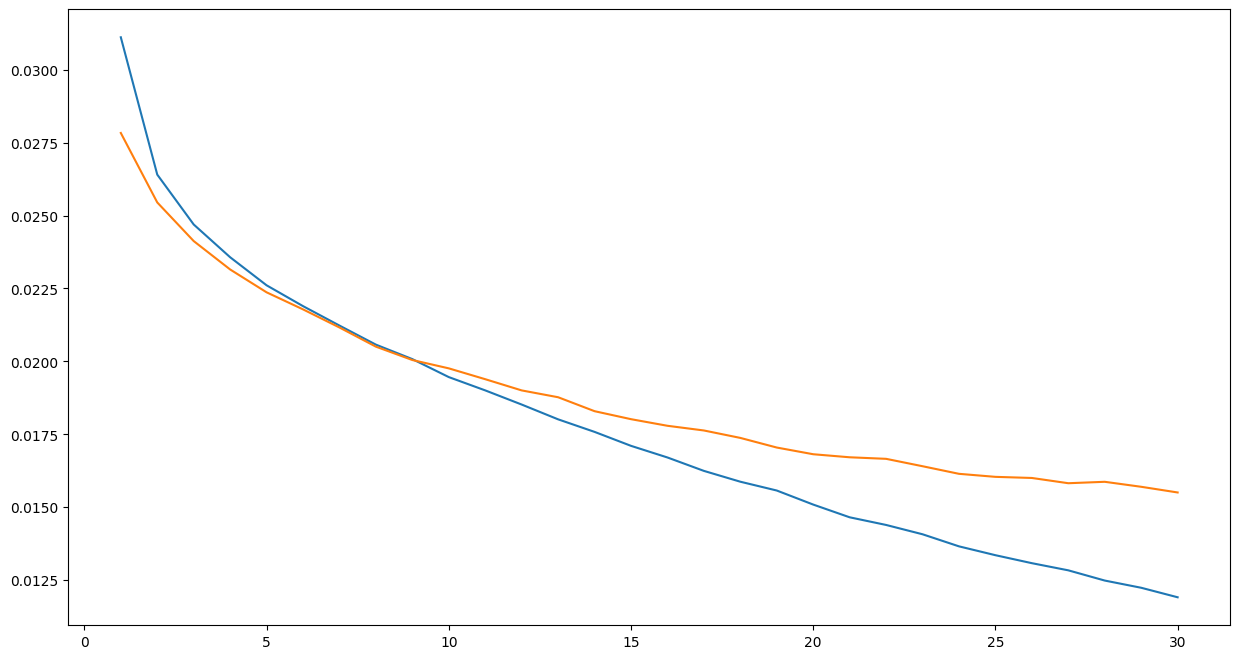

In [70]:
##shufflenet
## test for sgd,adam, lr=0.0001,momentum
model=models.shufflenet_v2_x0_5(weights=None)
model.fc=nn.Linear(model.fc.in_features,10)
model.to('cuda')


loss=nn.CrossEntropyLoss()

lr=0.0001
momentum=0
weight_decay=1e-6
optim=torch.optim.Adam(model.parameters(),lr,weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.01, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,30,scheduler=scheduler,plot=True)

torch.save(model,'mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

### Final Models and Testing

In [82]:
loss=nn.CrossEntropyLoss()
def test_model(model,test_dataloader,loss_fn):
    model.eval()
    total_loss=0
    accuracy=0
    with torch.no_grad():
        for batch,(data,target) in enumerate(test_dataloader):
            data=data.to('cuda',non_blocking=True)
            target=target.to('cuda',non_blocking=True)

            predictions=model(data)
            loss=loss_fn(predictions,target)
            total_loss+=loss.item()

            accuracy+=(predictions.argmax(dim=1)==target).sum()
    return (total_loss/len(test_datalaoder.dataset.targets)),(accuracy/len(test_datalaoder.dataset.targets))

epoch 1, lr [0.0001] -- train loss: 0.032875662949681285, train accuracy: 23.462499618530273,  val loss: 0.0303799446105957 , val accuracy: 29.94999885559082
epoch 2, lr [0.0001] -- train loss: 0.0290617776542902, train accuracy: 32.685001373291016,  val loss: 0.02811285364627838 , val accuracy: 34.880001068115234
epoch 3, lr [0.0001] -- train loss: 0.027271729004383086, train accuracy: 36.092498779296875,  val loss: 0.026569029581546784 , val accuracy: 38.07999801635742
epoch 4, lr [0.0001] -- train loss: 0.02589650755226612, train accuracy: 39.29499816894531,  val loss: 0.02513011610507965 , val accuracy: 41.2599983215332
epoch 5, lr [0.0001] -- train loss: 0.024765682193636895, train accuracy: 42.21500015258789,  val loss: 0.024346867990493775 , val accuracy: 43.21999740600586
epoch 6, lr [0.0001] -- train loss: 0.023848306924104692, train accuracy: 44.12249755859375,  val loss: 0.02335868127346039 , val accuracy: 45.78999710083008
epoch 7, lr [0.0001] -- train loss: 0.0230013650208

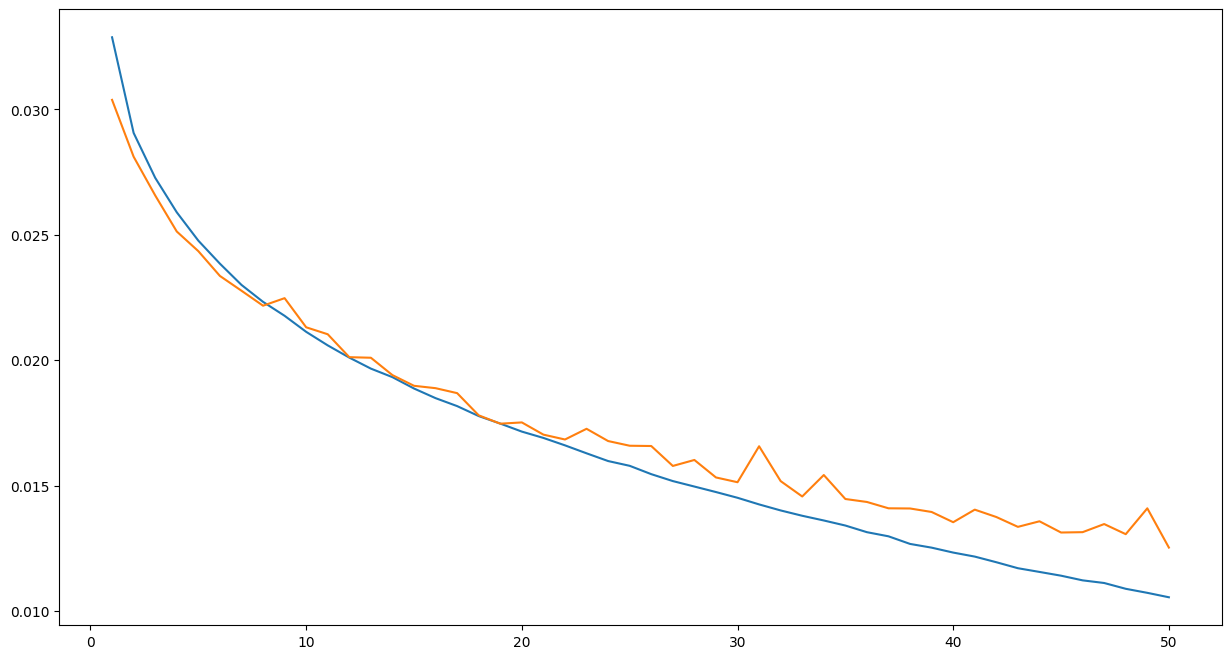

In [ ]:
##resnet18 final model
model=models.resnet18(weights=None)
model.fc=nn.Linear(model.fc.in_features,10)
model.to('cuda')

loss=nn.CrossEntropyLoss()

lr=0.0001
momentum=0.9
weight_decay=1e-6
optim=torch.optim.SGD(model.parameters(),lr,momentum=momentum,weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.05, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(model,loss,optim,50,scheduler=scheduler,plot=True)

torch.save(model,'resnet18_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('resnet18_'+str(lr)+'_'+str(momentum)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

In [84]:
loss=nn.CrossEntropyLoss()
resnet_final=model
test_model(resnet_final,test_dataloader=test_datalaoder,loss_fn=loss)

(0.01273125419318676, tensor(0.7127, device='cuda:0'))

epoch 1, lr [0.0001] -- train loss: 0.03535025926232338, train accuracy: 15.107499122619629,  val loss: 0.03470132348537445 , val accuracy: 17.329999923706055
epoch 2, lr [0.0001] -- train loss: 0.033146898698806763, train accuracy: 19.834999084472656,  val loss: 0.031211852300167084 , val accuracy: 24.709999084472656
epoch 3, lr [0.0001] -- train loss: 0.03001395689547062, train accuracy: 26.194997787475586,  val loss: 0.02881064518690109 , val accuracy: 29.009998321533203
epoch 4, lr [0.0001] -- train loss: 0.028396133524179457, train accuracy: 29.22249984741211,  val loss: 0.027954924213886262 , val accuracy: 30.649999618530273
epoch 5, lr [0.0001] -- train loss: 0.02764475902915001, train accuracy: 31.119998931884766,  val loss: 0.027287386310100557 , val accuracy: 32.060001373291016
epoch 6, lr [0.0001] -- train loss: 0.027047976738214494, train accuracy: 32.932498931884766,  val loss: 0.02669097547531128 , val accuracy: 34.03999710083008
epoch 7, lr [0.0001] -- train loss: 0.0266

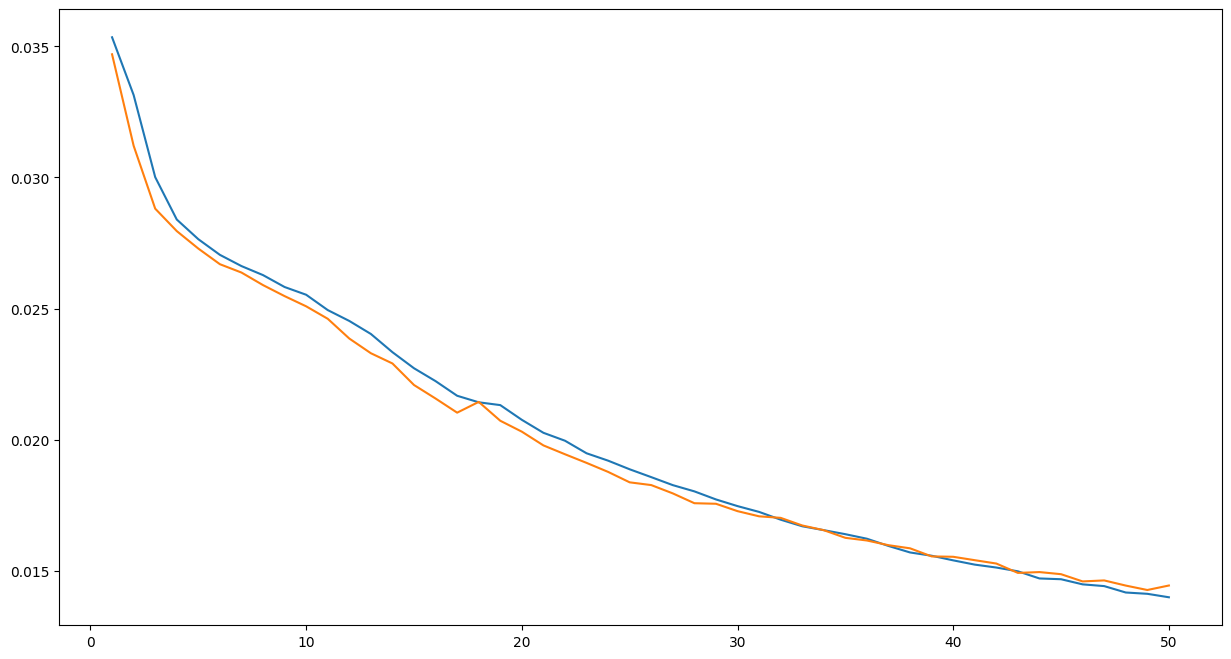

In [85]:
##mobilnetv2 model
mobilenet_final=models.MobileNetV2(num_classes=10,width_mult=0.5)
mobilenet_final.to('cuda')

loss=nn.CrossEntropyLoss()

lr=0.0001
momentum=0.9
weight_decay=1e-6
optim=torch.optim.SGD(mobilenet_final.parameters(),lr,weight_decay=weight_decay,momentum=momentum)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(mobilenet_final,loss,optim,50,scheduler=scheduler,plot=True)

torch.save(mobilenet_final,'mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

In [86]:
loss=nn.CrossEntropyLoss()
test_model(mobilenet_final,test_dataloader=test_datalaoder,loss_fn=loss)

(0.014731779098510742, tensor(0.6691, device='cuda:0'))

epoch 1, lr [0.01] -- train loss: 0.0318212982326746, train accuracy: 21.899999618530273,  val loss: 0.028792779314517975 , val accuracy: 29.389997482299805
epoch 2, lr [0.01] -- train loss: 0.02758034150004387, train accuracy: 30.93499755859375,  val loss: 0.026859536838531494 , val accuracy: 33.30999755859375
epoch 3, lr [0.01] -- train loss: 0.02636609913408756, train accuracy: 35.3125,  val loss: 0.025789436280727388 , val accuracy: 37.64999771118164
epoch 4, lr [0.01] -- train loss: 0.025159279024600984, train accuracy: 39.09000015258789,  val loss: 0.024500933277606964 , val accuracy: 40.82999801635742
epoch 5, lr [0.01] -- train loss: 0.023849377858638762, train accuracy: 42.64249801635742,  val loss: 0.023150500881671907 , val accuracy: 45.06999969482422
epoch 6, lr [0.01] -- train loss: 0.02260150651037693, train accuracy: 46.459999084472656,  val loss: 0.022499776756763457 , val accuracy: 47.56999969482422
epoch 7, lr [0.01] -- train loss: 0.021407184213399887, train accuracy

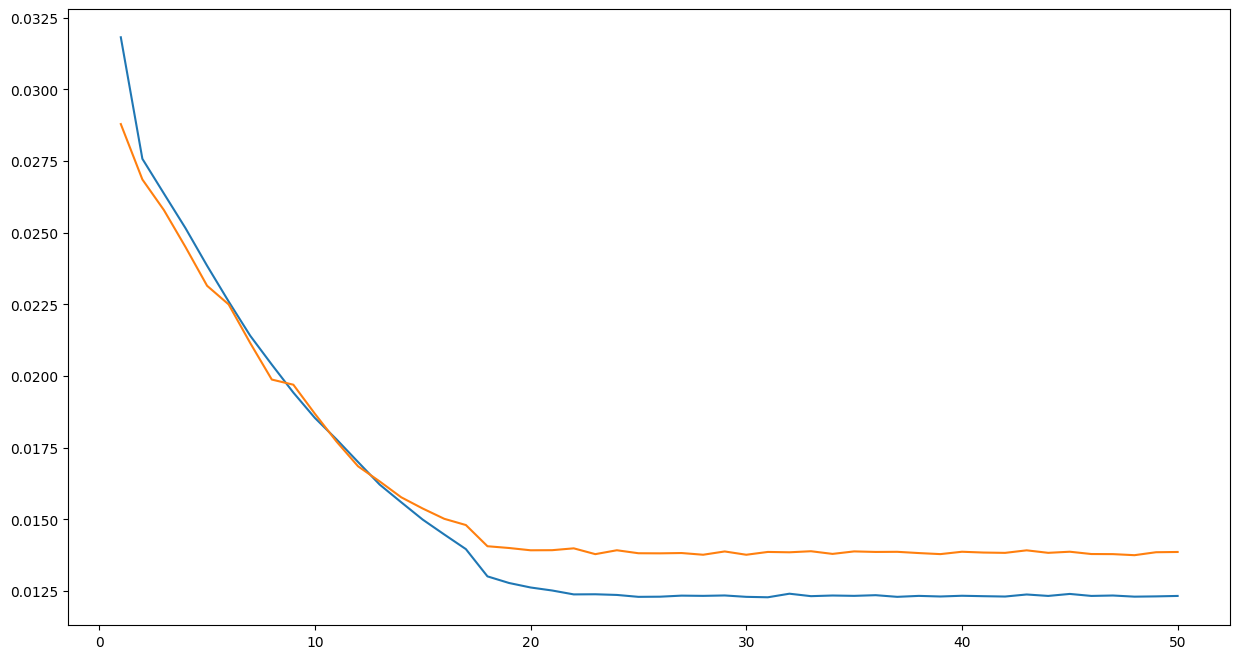

In [92]:
##shufflenet
## test for sgd,lr=0.001,momentum
shufflenet_final=models.shufflenet_v2_x0_5(weights=None)
shufflenet_final.fc=nn.Linear(shufflenet_final.fc.in_features,10)
shufflenet_final.to('cuda')


loss=nn.CrossEntropyLoss()

lr=0.01
momentum=0
weight_decay=1e-6
optim=torch.optim.SGD(shufflenet_final.parameters(),lr,weight_decay=weight_decay,momentum=momentum)
scheduler = ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=2, threshold=0.1, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)


train_loss,train_accuracy,val_loss,val_accuracy=fit(shufflenet_final,loss,optim,50,scheduler=scheduler,plot=True)

torch.save(shufflenet_final,'mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+".pt")

train_accuracy=torch.tensor(train_accuracy).tolist()
val_accuracy=torch.tensor(val_accuracy).tolist()
resutls={'train_loss':train_loss,'train accuracy':train_accuracy,'validation loss':val_loss,'validation accuracy':val_accuracy}
with open('mobilenetv2_'+str(lr)+'_'+str(type (optim).__name__)+'.json','w') as f:
    json.dump(resutls,f)

In [93]:
loss=nn.CrossEntropyLoss()
test_model(shufflenet_final,test_dataloader=test_datalaoder,loss_fn=loss)

(0.014017938953638077, tensor(0.6821, device='cuda:0'))